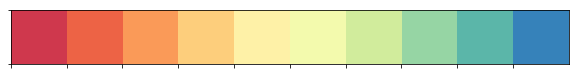

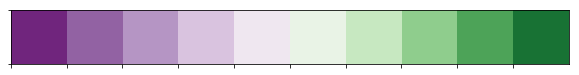

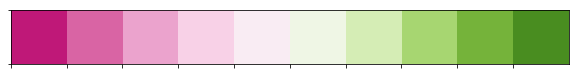

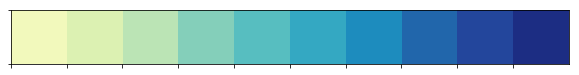

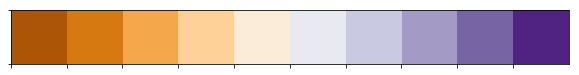

In [14]:
%matplotlib inline
import ast
from bs4 import BeautifulSoup
from config import api_key_tmdb
import csv
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import re
import requests
from scipy import stats
import seaborn as sns
sns.palplot(sns.color_palette("Spectral", 10))
sns.palplot(sns.color_palette("PRGn", 10))
sns.palplot(sns.color_palette("PiYG", 10))
sns.palplot(sns.color_palette("YlGnBu", 10))
sns.palplot(sns.color_palette("PuOr", 10))
import sqlite3
from sqlite3 import Error
import time

In [15]:
# Importing the IMDB movies file
data = "imdb_movies_data.csv"
use_cols = ["imdb_id", "imdb_score", "meta_score"]

# Using pandas.read_csv method to load the file
imdb_df = pd.read_csv(data, usecols = use_cols)
imdb_df = imdb_df.set_index("imdb_id")

In [16]:
# Replace missing data in the "imdb_score" and "meta_score" columns with NumPy NaN values
imdb_df["imdb_score"] = imdb_df["imdb_score"].replace(" ", np.nan)
imdb_df["meta_score"] = imdb_df["meta_score"].replace(" ", np.nan)

In [18]:
# Importing the TMDB Movies file
data = "tmdb_movies_cast_df.csv"

# Using pandas.read_csv method to load the file
tmdb_df = pd.read_csv(data, lineterminator='\n')
tmdb_df = tmdb_df.set_index("id")
tmdb_df = tmdb_df.merge(imdb_df, how = "left", on = "imdb_id")

In [19]:
# Using pandas.to_numeric to coerce the "id", "budget" and "revenue" columns into numbers
tmdb_df["budget"] = pd.to_numeric(tmdb_df["budget"], downcast = "integer", errors = "coerce")
tmdb_df["revenue"] = pd.to_numeric(tmdb_df["revenue"], downcast = "integer", errors = "coerce")

# Lambda function to strip and split "release_date" string values
f = lambda x: str(x).strip().split('-')[0] if x != np.nan else np.nan

# Creating a new column, "year", and assigninf the value of "release_date" 
# After applying the lambda function through map
tmdb_df["year"] = tmdb_df["release_date"].map(f)

# Coerce the "year" column to integers
tmdb_df["year"] = pd.to_numeric(tmdb_df["year"], errors = "coerce")

# Convert "release_date" column to datetime format
tmdb_df["release_date"] = pd.to_datetime(tmdb_df["release_date"])

tmdb_df["title"] = tmdb_df["title"].astype("str")

tmdb_df["overview"] = tmdb_df["overview"].astype("str")

In [20]:
# Divide "release_date" column in months
tmdb_df["month_of_year"] = tmdb_df["release_date"].dt.month_name()

# Divide "release_date" column in months
tmdb_df["day_of_week"] = tmdb_df["release_date"].dt.day_name()

In [21]:
tmdb_df = tmdb_df.drop(["release_date"], axis=1)

In [22]:
tmdb_df_revenue = tmdb_df[tmdb_df["revenue"].notnull()][["title", "budget", "revenue", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity", "imdb_score", "meta_score"]].sort_values("popularity", ascending = False)

tmdb_df_revenue = tmdb_df_revenue.dropna(subset=["budget"])


In [23]:
# Function to create a new SQLite3 Database
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        conn.close()

In [24]:
# Use create_connection function to create Database
create_connection("movies.db")

In [25]:
# Create a connection object using the connect function 
# To establish a connection with "movies.db"
connection = sqlite3.connect("movies.db")
# Create a cursor object by calling the cursor method
cursor = connection.cursor()

In [27]:
# Write records stored in the imdb_df DataFrame to a SQL database
imdb_df.to_sql("imdb_movies", con = connection)

OperationalError: table "imdb_movies" already exists

In [98]:
# Write records stored in the tmdb_df DataFrame to a SQL database
tmdb_df.to_sql("tmdb_movies", con = connection)

In [28]:
combined_df = pd.read_sql_query('''
SELECT
    id,
    title, 
    belongs_to_collection, 
    budget, 
    genres,
    overview, 
    revenue, 
    tagline, 
    director_name,
    leading_actor_name,
    supporting_actor_name,
    vote_average, 
    vote_count, 
    runtime, 
    popularity, 
    production_companies,
    year,
    month_of_year,
    day_of_week,
    tmdb_movies.imdb_id AS tmdb_imdb_id,
    imdb_movies.imdb_id AS imdb_id,
    imdb_score
    meta_score
FROM
    tmdb_movies
    INNER JOIN imdb_movies ON tmdb_movies.imdb_id = imdb_movies.imdb_id;''', connection)

DatabaseError: Execution failed on sql '
SELECT
    id,
    title, 
    belongs_to_collection, 
    budget, 
    genres,
    overview, 
    revenue, 
    tagline, 
    director_name,
    leading_actor_name,
    supporting_actor_name,
    vote_average, 
    vote_count, 
    runtime, 
    popularity, 
    production_companies,
    year,
    month_of_year,
    day_of_week,
    tmdb_movies.imdb_id AS tmdb_imdb_id,
    imdb_movies.imdb_id AS imdb_id,
    imdb_score
    meta_score
FROM
    tmdb_movies
    INNER JOIN imdb_movies ON tmdb_movies.imdb_id = imdb_movies.imdb_id;': ambiguous column name: title

In [29]:
pd.read_sql_query('''SELECT title, MAX(popularity) FROM tmdb_movies''', connection)

,title,MAX(popularity)
0,Bumblebee,226.241


In [30]:
pd.read_sql_query('''SELECT title, MAX(revenue) FROM tmdb_movies''', connection)

,title,MAX(revenue)
0,Avatar,2.787965e+09


In [217]:
pd.read_sql_query('''SELECT title, MAX(budget) FROM tmdb_movies''', connection)

,title,MAX(budget)
0,Justice League,500000000.0


In [218]:
pd.read_sql_query('''SELECT title, MIN(budget) FROM tmdb_movies''', connection)

,title,MIN(budget)
0,The Hunted,1.0


In [340]:
pd.read_sql_query('''SELECT title, MIN(popularity) FROM tmdb_movies''', connection)

,title,MIN(popularity)
0,Resident Evil: Afterlife,0.6


In [32]:
tmdb_runtime = tmdb_df[tmdb_df["runtime"] > 0][["runtime", "year", "popularity", "imdb_score", 
                                                "meta_score", "budget", "revenue"]].sort_values("popularity", ascending = False)
tmdb_runtime.head()

,runtime,year,popularity,imdb_score,meta_score,budget,revenue
3,114.0,2018.0,226.241,7.0,66,135000000.0,4.203613e+08
24,107.0,2018.0,148.786,6.6,NaN,NaN,NaN
2,149.0,2018.0,129.988,8.5,68,300000000.0,2.046240e+09
1,144.0,2018.0,129.402,7.2,55,160000000.0,1.143689e+09
0,117.0,2018.0,115.129,8.5,87,90000000.0,3.628236e+08


In [33]:
tmdb_df_rel = tmdb_df[tmdb_df["imdb_id"].notnull()][["title", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity"]]

tmdb_df_revenue_rel = tmdb_df[tmdb_df["revenue"].notnull()][["title", "budget", "revenue", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity"]]

/Users/fhel/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/fhel/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


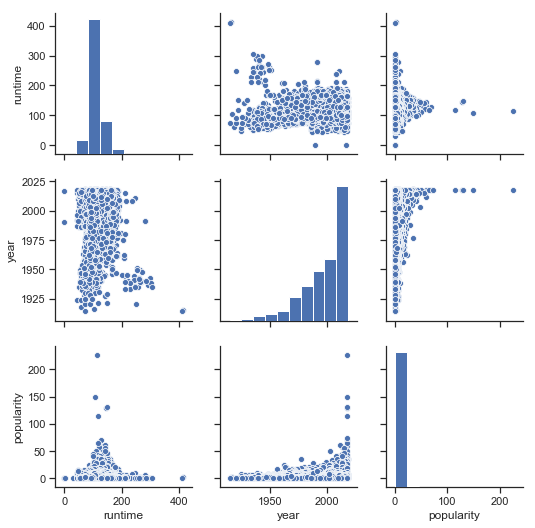

In [34]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(tmdb_df_rel)

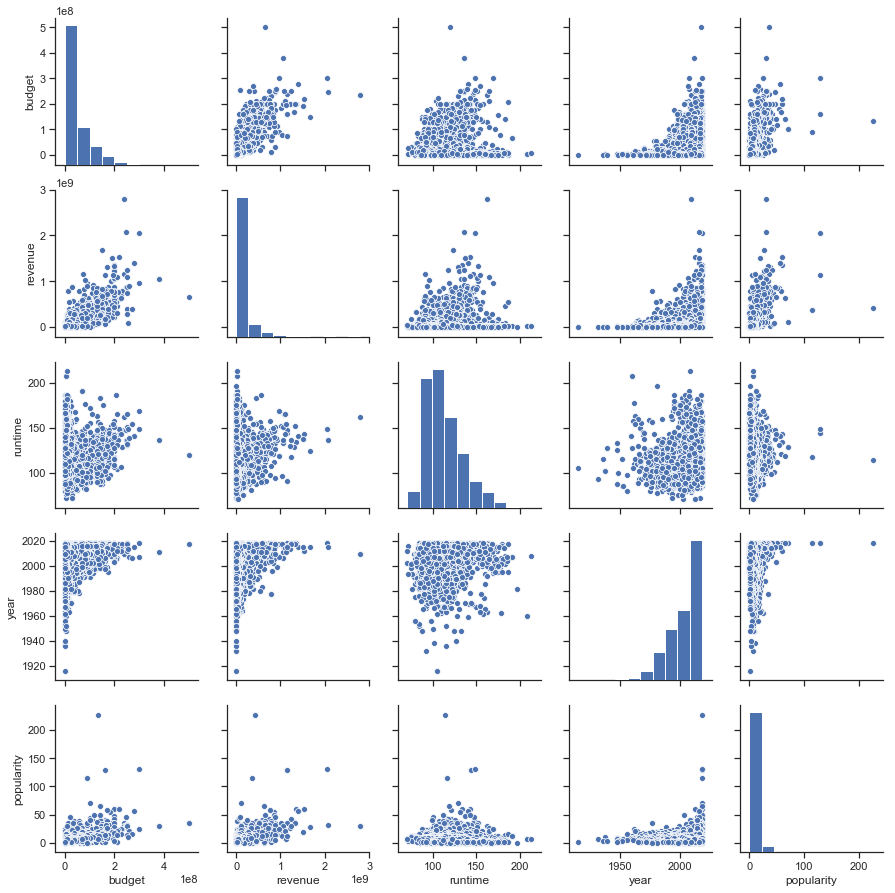

In [308]:
sns.pairplot(tmdb_df_revenue_rel)

In [35]:
less_popular = tmdb_df[tmdb_df["popularity"].notnull()][["title", "tagline", 
                        "popularity", "year", "overview", "director_name", 
                            "leading_actor_name", "supporting_actor_name", "budget"]].sort_values("popularity").head(100)

In [36]:
less_popular.head()

,title,tagline,popularity,year,overview,director_name,leading_actor_name,supporting_actor_name,budget
6362,King of Kong Island,NaN,0.6,1992.0,Drama about a young man from India whose lack ...,NaN,NaN,NaN,NaN
7042,Pariah,It's just a matter of time...,0.6,2016.0,When his family gets killed by corrupt busines...,NaN,NaN,NaN,NaN
7045,Crocodile 2: Death Swamp,NaN,0.6,1914.0,"Blamed for th theft of an orphans fund, Captai...",NaN,NaN,NaN,NaN
5108,The Merciless,NaN,0.6,2015.0,"A woman runs a massage parlor in Dharavi, Mumbai.",NaN,NaN,NaN,NaN
8393,Island of Greed,NaN,0.6,1988.0,An American military advisor becomes disillusi...,NaN,NaN,NaN,NaN


In [37]:
less_popular_title = pd.Series(' '.join(less_popular["title"]).lower().split()).value_counts()[:200]

In [38]:
less_popular_overview = pd.Series(' '.join(less_popular["overview"]).lower().split()).value_counts()[:200]

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Month')]

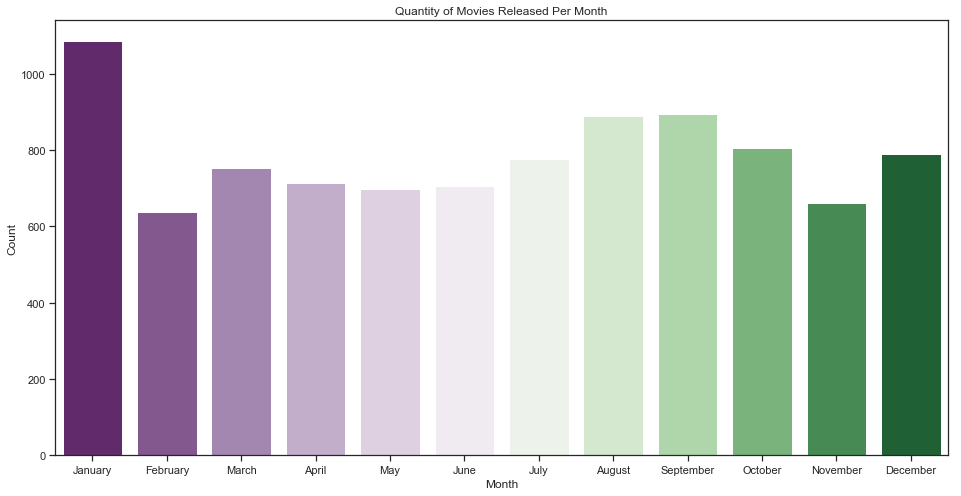

In [58]:
plt.figure(figsize=(16,8))
plt.title("Quantity of Movies Released Per Month")
ax = sns.countplot(x = "month_of_year", data = tmdb_df, palette = "PRGn", order = ["January", "February", 
                                                                              "March", "April", "May",
                                                                             "June", "July", "August",
                                                                             "September", "October",
                                                                             "November", "December"])
ax.set(xlabel='Month', ylabel='Count')

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Days')]

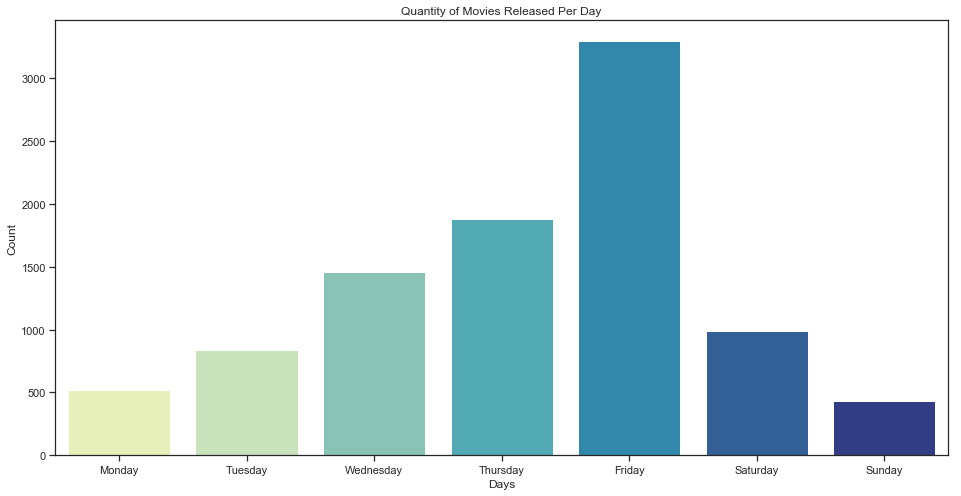

In [51]:
plt.figure(figsize=(16,8))
plt.title("Quantity of Movies Released Per Day")
ax2 = sns.countplot(x = "day_of_week", data = tmdb_df, palette = "YlGnBu", order = ["Monday", "Tuesday", 
                                                                              "Wednesday", "Thursday", "Friday",
                                                                             "Saturday", "Sunday"])
ax2.set(xlabel='Days', ylabel='Count')

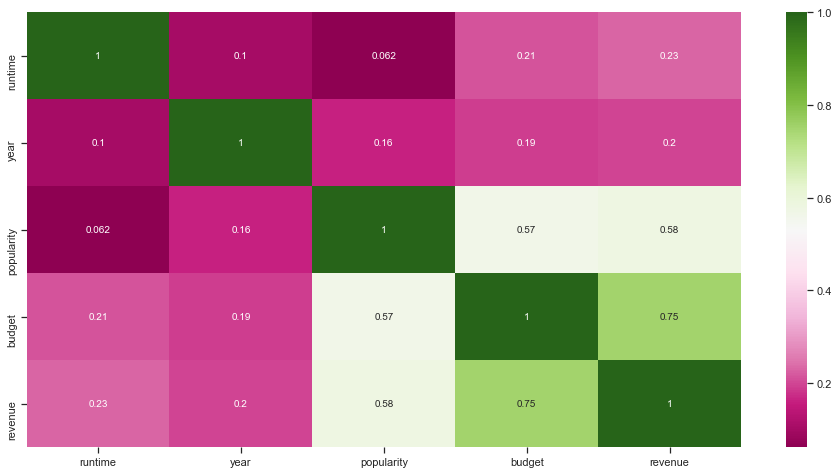

In [338]:
plt.figure(figsize = (16, 8))
sns.heatmap(tmdb_runtime.corr(), annot = True, cmap = "PiYG")

[Text(0, 0.5, 'Revenue'), Text(0.5, 0, 'Month')]

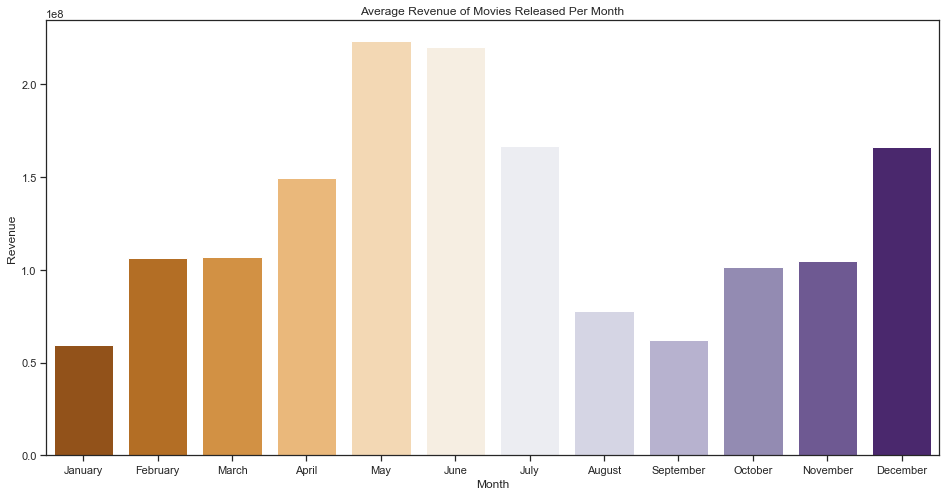

In [55]:
month_df = tmdb_df_revenue[tmdb_df_revenue["month_of_year"].notnull()][["revenue", "month_of_year"]]
avg_rev_month = month_df.groupby("month_of_year").mean()
avg_rev_month.reset_index(inplace = True)
plt.figure(figsize = (16, 8))
plt.title("Average Revenue of Movies Released Per Month")
ax = sns.barplot(x = "month_of_year", y = "revenue", palette = "PuOr", data = avg_rev_month, order = ["January", "February", 
                                                                              "March", "April", "May",
                                                                             "June", "July", "August",
                                                                             "September", "October",
                                                                             "November", "December"])
ax.set(xlabel='Month', ylabel='Revenue')

[Text(0, 0.5, 'Revenue'), Text(0.5, 0, 'Day')]

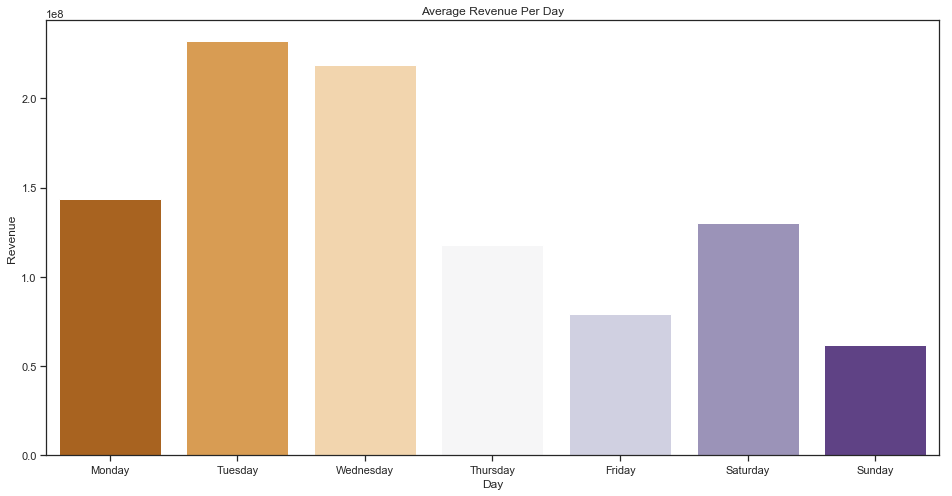

In [57]:
day_df = tmdb_df_revenue[tmdb_df_revenue["day_of_week"].notnull()][["revenue", "day_of_week"]]
avg_rev_day = day_df.groupby("day_of_week").mean()
avg_rev_day.reset_index(inplace = True)
plt.figure(figsize = (16, 8))
plt.title("Average Revenue Per Day")
ax = sns.barplot(x = "day_of_week", y = "revenue", palette = "PuOr", data = avg_rev_day, order = ["Monday", "Tuesday", 
                                                                              "Wednesday", "Thursday", "Friday",
                                                                             "Saturday", "Sunday"])
ax.set(xlabel='Day', ylabel='Revenue')